# Training notes

## 0. Initialize environments

https://github.com/phizaz/diffae.git

pip install -r requirements.txt

## 1. Install arcface in the folder and datasets

Send a copy of the file dir

## 2. Run the training

In [1]:
import os
CODE_DIR = '/home/joshua/Projects/diffae'
os.chdir(f'{CODE_DIR}')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
# !python run_celeba64.py

In [4]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

In [5]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [8]:
image_data = ImageDataset('01000', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)

In [9]:
len(image_data)

999

In [8]:
batch = image_data[11]['img'][None]

In [9]:
cond = model.encode(batch.to(device))
xT = model.encode_stochastic(batch.to(device), cond, T=250)

In [19]:
np.shape(data[3]['img'][None])

torch.Size([1, 3, 256, 256])

In [42]:
np.shape(cond)

torch.Size([1, 512])

In [6]:
BASE_PATH = '/home/joshua/Projects/diffae/disentanglement/'

In [3]:
import sys
sys.path.append('/home/joshua/Projects/diffae/disentanglement/')

from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.LatentMapper import LatentMapper
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

In [7]:
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

In [8]:
id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)
attr_encoder = torch.load(MODELS_DIR + 'attr_encoder_HPMNYYOTTIXN_1616315604.9508004_0.pt')
attr_encoder = Inception(attr_encoder)
# discriminator = Discriminator()
mlp = LatentMapper()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
# generator = Generator(GENERATOR_IMAGE_SIZE, 512, 8)

Loading ResNet ArcFace


In [9]:
mlp = torch.load(MODELS_DIR + 'maper_HPMNYYOTTIXN_1616315604.542634_0.pt')

In [10]:
id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
# discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
# generator = generator.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

In [11]:
id_encoder = id_encoder.eval()
attr_encoder = attr_encoder.eval()
# discriminator = discriminator.eval()
# generator = generator.eval()
mlp = mlp.eval()
landmark_encoder = landmark_encoder.eval()

In [20]:
w_image_dataset = Image_W_Dataset(W_DATA_DIR, IMAGE_DATA_DIR)
data_loader = DataLoader(dataset=w_image_dataset, batch_size=1, shuffle=False)

In [21]:
data_id = next(iter(data_loader))

In [22]:
ws, images = data_id

In [23]:
np.shape(images)

torch.Size([1, 3, 256, 256])

In [24]:
def get_concat_vec(id_images, attr_images, id_encoder, attr_encoder):
    with torch.no_grad():
        id_vec = torch.squeeze(id_encoder.extract_feats((id_images * 2) - 1))
        attr_vec = torch.squeeze(attr_encoder(attr_images))
        test_vec = torch.cat((id_vec, attr_vec), dim=1)
        return test_vec

In [25]:
test_ws = ws.to(Global_Config.device)
test_id_images = images.to(Global_Config.device)
# test_attr_images_cycled = cycle_images_to_create_diff_order(test_id_images)
with torch.no_grad():
    id_vec = torch.squeeze(id_encoder.extract_feats((test_id_images * 2) - 1))[None]
    attr_vec = torch.squeeze(attr_encoder(test_id_images))[None]
    test_vec = torch.cat((id_vec, attr_vec), dim=1)
    

In [39]:
np.shape(test_vec)

torch.Size([1, 2560])

In [40]:
with torch.no_grad():
    semantic_vec = mlp(test_vec)

In [41]:
np.shape(semantic_vec)

torch.Size([1, 512])

## Train!!

In [1]:
import os
CODE_DIR = '/home/joshua/Projects/diffae'
os.chdir(f'{CODE_DIR}')

In [2]:
from pytorch_msssim import ms_ssim
import torch
import lpips

l1_criterion = torch.nn.L1Loss(reduction='mean')
l2_criterion = torch.nn.MSELoss(reduction='mean')


def rec_loss(attr_images, generated_images, a):
    ms_ssim_loss = 1 - ms_ssim(attr_images, generated_images, data_range=1, size_average=True)
    l1_loss_value = l1_criterion(attr_images, generated_images)
    return a * ms_ssim_loss + (1 - a) * l1_loss_value


def id_loss(encoded_input_image, encoded_generated_image):
    return l1_criterion(encoded_input_image, encoded_generated_image)


def landmark_loss(input_attr_lnd, output_lnd):
    loss = l2_criterion(input_attr_lnd, output_lnd)
    return loss


def l2_loss(attr_images, generated_images):
    loss = l2_criterion(attr_images, generated_images)
    return loss

In [3]:
from templates import *
from templates_cls import *
from experiment_classifier import ClsModel

import sys
sys.path.append('/home/joshua/Projects/diffae/disentanglement/')

from Configs import Global_Config
from Configs.training_config import config, GENERATOR_IMAGE_SIZE
from Training.trainer import Trainer
from torch.utils.data import DataLoader, random_split
from Models.Encoders.Landmark_Encoder import Landmark_Encoder
from Models.Encoders.ID_Encoder import ID_Encoder
from Models.Encoders.Inception import Inception
from Models.LatentMapper import LatentMapper
from Utils.data_utils import get_w_image, Image_W_Dataset, cycle_images_to_create_diff_order
import time
import torch.utils.data
from tqdm import tqdm
from Losses import id_loss

device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

BASE_PATH = '/home/joshua/Projects/diffae/disentanglement/'
MOBILE_FACE_NET_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/mobilefacenet_model_best.pth.tar'
GENERATOR_WEIGHTS_PATH = BASE_PATH + 'CNN-project-weights/550000.pt'
E_ID_LOSS_PATH = BASE_PATH + 'CNN-project-weights/model_ir_se50.pth'
IMAGE_DATA_DIR = BASE_PATH + 'Dataset/small_image/'
W_DATA_DIR = BASE_PATH + 'Dataset/small_w/'
MODELS_DIR = BASE_PATH + 'Models/'

id_encoder = id_loss.IDLoss(E_ID_LOSS_PATH)
# attr_encoder = torch.load(MODELS_DIR + 'attr_encoder_HPMNYYOTTIXN_1616315604.9508004_0.pt')
attr_encoder = torch.load('/home/joshua/Projects/diffae/checkpoints/attr/attr_ffhq01000_full.pt')
attr_encoder = Inception(attr_encoder)
# discriminator = Discriminator()
mlp = LatentMapper()
landmark_encoder = Landmark_Encoder.Encoder_Landmarks(MOBILE_FACE_NET_WEIGHTS_PATH)
# mlp = torch.load(MODELS_DIR + 'maper_HPMNYYOTTIXN_1616315604.542634_0.pt')
mlp = torch.load('/home/joshua/Projects/diffae/checkpoints/MLP/mlp_ffhq01000_full.pt')

id_encoder = id_encoder.to(Global_Config.device)
attr_encoder = attr_encoder.to(Global_Config.device)
# discriminator = discriminator.to(Global_Config.device)
mlp = mlp.to(Global_Config.device)
landmark_encoder = landmark_encoder.to(Global_Config.device)

id_encoder = id_encoder.eval()
lpips_loss = lpips.LPIPS(net='alex').to(Global_Config.device).eval()
landmark_encoder = landmark_encoder.eval()
attr_encoder = attr_encoder.train()

mlp = mlp.train()


Global seed set to 0


Model params: 160.69 M
Loading ResNet ArcFace
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/joshua/anaconda3/envs/proj0/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [5]:
import torch.nn as nn
L2 = nn.MSELoss()

config = {
    'beta1' : 0.5,
    'beta2' : 0.999,
    'lrD' : 0.0004,
    'lrMLP' : 0.00003,
    'lrAttr' : 0.0001,
    'non_adverserial_lr': 6e-5,
    'IdDiffersAttrTrainRatio' : 3, # 1/3
    'batchSize' : 8,
    'R1Param' : 10,
    'lambdaID' : 1,
    'lambdaLND' : 1,
    'lambdaREC' : 1,
    'lambdaL2' : 1,
    'lambdaVGG' : 1,
    'a': 0.84
}

optimizerMLP = torch.optim.Adam(mlp.parameters(), lr=config['lrMLP'], betas=(config['beta1'], config['beta2']))
optimizer_non_adv_M = torch.optim.Adam(list(mlp.parameters()) + list(attr_encoder.parameters()),
                                       lr=config['non_adverserial_lr'], betas=(config['beta1'], config['beta2']))
image_data = ImageDataset('01000', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
print(len(image_data))

999


### Prepare data (Generate XT)

In [5]:
# data_files = ['00000','01000','02000','03000','04000','05000','06000','07000','08000','09000']
data_files = ['01000']
xT_list = []
for data_file in data_files:
    image_data = ImageDataset(data_file, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
    print(data_file)
    for idx, data in enumerate(image_data):
        batch = data['img'][None]
        torch.cuda.empty_cache()
        id_images = batch.cuda()
        with torch.no_grad():
            semantic_vec_true = model.encode(id_images)
            xT_true = model.encode_stochastic(id_images, semantic_vec_true, T=50)
        xT_id = xT_true[0].cpu()
        xT_list.append(xT_id)
        print(idx)

01000
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


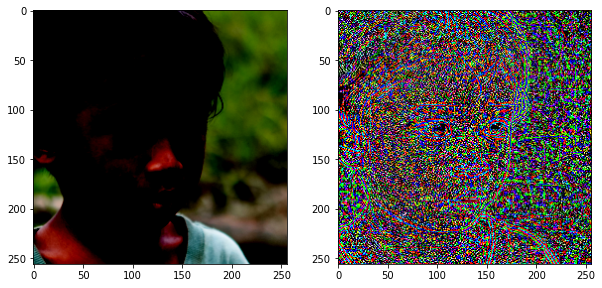

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT_true[0].permute(1, 2, 0).cpu())

In [7]:
torch.save(xT_list, 'FFHQ_xT_data/xT_list_01000.pt')

In [6]:
xT_list = torch.load('FFHQ_xT_data/xT_list_01000.pt')

In [6]:
len(xT_list)

996

In [26]:
np.shape(xT_list[0].cuda())

torch.Size([3, 256, 256])

In [8]:
for idx, data in enumerate(image_data):
    batch = data['img'][None]

In [11]:
np.shape(batch)

torch.Size([1, 3, 256, 256])

In [17]:
torch.max((batch[0].permute(1, 2, 0).cpu()+1)/2)

tensor(1.)

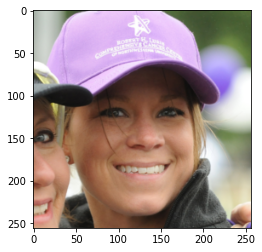

In [18]:
import matplotlib.pyplot as plt
plt.imshow((batch[0].permute(1, 2, 0).cpu()+1)/2)

### Train single 1000 data

In [7]:
epochs = 1
for epoch in range(epochs):
    for idx, data in enumerate(image_data):
        batch = data['img'][None]
        torch.cuda.empty_cache()
        id_images = batch.cuda()
        attr_batch = batch*0.5+0.5
        attr_images = attr_batch.cuda()
        xT_true = xT_list[idx][None]
        xT_true = xT_true.cuda()
        
        total_loss = torch.tensor(0, dtype=torch.float, device=Global_Config.device)
    
        with torch.no_grad():
            id_vec = id_encoder.extract_feats(id_images)
            attr_vec = torch.squeeze(attr_encoder(attr_images))[None]
            encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
            semantic_vec_true = model.encode(id_images)
            
            semantic_vec = mlp(encoded_vec)
            generated_img = model.render(xT_true, semantic_vec, T=50)
        
        id_encoder.zero_grad()
        landmark_encoder.zero_grad()
        
        ## -1 to 1
        id_loss_val = config['lambdaID'] * id_encoder(generated_img*2-1, id_images)
        total_loss += id_loss_val
        
        ## 0 to 1
        rec_loss_val = config['lambdaREC'] * rec_loss(attr_images, generated_img, config['a'])
        total_loss += rec_loss_val
        
        l2_loss_val = config['lambdaL2'] * l2_loss(attr_images, generated_img)
        total_loss += l2_loss_val
        ## -1 to 1
        vgg_loss_val = torch.mean(config['lambdaVGG'] * lpips_loss(generated_img*2-1, id_images))
        total_loss += vgg_loss_val
        
        optimizer_non_adv_M.zero_grad() 
        total_loss.backward()
        optimizer_non_adv_M.step()
        
        print('id_loss_val:',id_loss_val.item(),'rec_loss_val:',rec_loss_val.item(),'l2_loss_val:',l2_loss_val.item(),'vgg_loss_val:',vgg_loss_val.item())
        print(f"\n loss:", total_loss.item(), 'idx:', idx)

#     MLP_losses.append(g_error)
#     D_losses.append((error_real + error_fake) /2)

#     if idx % 5 == 0:
#         with torch.no_grad():
#             plot_w_image(mlp(test_vec)[0])

id_loss_val: 0.9707577228546143 rec_loss_val: 0.5077536702156067 l2_loss_val: 0.06364411115646362 vgg_loss_val: 0.504150390625

 loss: 2.0463058948516846 idx: 0
id_loss_val: 0.6357382535934448 rec_loss_val: 0.43883055448532104 l2_loss_val: 0.04251166433095932 vgg_loss_val: 0.45655548572540283

 loss: 1.5736359357833862 idx: 1
id_loss_val: 0.5155965089797974 rec_loss_val: 0.39777860045433044 l2_loss_val: 0.03976808488368988 vgg_loss_val: 0.4157086908817291

 loss: 1.368851900100708 idx: 2
id_loss_val: 0.6686375141143799 rec_loss_val: 0.3964441418647766 l2_loss_val: 0.061996739357709885 vgg_loss_val: 0.4333474934101105

 loss: 1.5604257583618164 idx: 3
id_loss_val: 0.7528409957885742 rec_loss_val: 0.5421423316001892 l2_loss_val: 0.043375857174396515 vgg_loss_val: 0.5257683992385864

 loss: 1.8641276359558105 idx: 4
id_loss_val: 0.8179818987846375 rec_loss_val: 0.6190527081489563 l2_loss_val: 0.11599011719226837 vgg_loss_val: 0.48084425926208496

 loss: 2.0338690280914307 idx: 5
id_loss_v

id_loss_val: 0.888325572013855 rec_loss_val: 0.3989352285861969 l2_loss_val: 0.08409082144498825 vgg_loss_val: 0.5922001004219055

 loss: 1.9635517597198486 idx: 50
id_loss_val: 0.8572399616241455 rec_loss_val: 0.519391655921936 l2_loss_val: 0.061628054827451706 vgg_loss_val: 0.43973252177238464

 loss: 1.8779922723770142 idx: 51
id_loss_val: 0.7542723417282104 rec_loss_val: 0.5066190361976624 l2_loss_val: 0.0737559050321579 vgg_loss_val: 0.45240119099617004

 loss: 1.7870484590530396 idx: 52
id_loss_val: 0.6477274894714355 rec_loss_val: 0.42391344904899597 l2_loss_val: 0.03952649608254433 vgg_loss_val: 0.45901918411254883

 loss: 1.5701866149902344 idx: 53
id_loss_val: 0.7844280004501343 rec_loss_val: 0.47759386897087097 l2_loss_val: 0.06243991106748581 vgg_loss_val: 0.4722731113433838

 loss: 1.7967349290847778 idx: 54
id_loss_val: 0.6538715362548828 rec_loss_val: 0.466697096824646 l2_loss_val: 0.042150553315877914 vgg_loss_val: 0.4957551956176758

 loss: 1.658474326133728 idx: 55
id

id_loss_val: 0.7043566703796387 rec_loss_val: 0.3972516357898712 l2_loss_val: 0.05512192100286484 vgg_loss_val: 0.4320884048938751

 loss: 1.5888185501098633 idx: 100
id_loss_val: 0.5002815127372742 rec_loss_val: 0.38651376962661743 l2_loss_val: 0.06460534781217575 vgg_loss_val: 0.35629528760910034

 loss: 1.3076958656311035 idx: 101
id_loss_val: 0.7902633547782898 rec_loss_val: 0.5433326363563538 l2_loss_val: 0.09277366101741791 vgg_loss_val: 0.5326052308082581

 loss: 1.958974838256836 idx: 102
id_loss_val: 0.5553112030029297 rec_loss_val: 0.4227437674999237 l2_loss_val: 0.10234124958515167 vgg_loss_val: 0.46411195397377014

 loss: 1.5445082187652588 idx: 103
id_loss_val: 0.7603425979614258 rec_loss_val: 0.6057939529418945 l2_loss_val: 0.07713159918785095 vgg_loss_val: 0.5173311233520508

 loss: 1.9605993032455444 idx: 104
id_loss_val: 0.7730467319488525 rec_loss_val: 0.5384687185287476 l2_loss_val: 0.06574811041355133 vgg_loss_val: 0.5409637093544006

 loss: 1.918227195739746 idx: 1

id_loss_val: 0.5884859561920166 rec_loss_val: 0.46238356828689575 l2_loss_val: 0.11057212948799133 vgg_loss_val: 0.48720264434814453

 loss: 1.648644208908081 idx: 150
id_loss_val: 0.7338080406188965 rec_loss_val: 0.3906382620334625 l2_loss_val: 0.045794274657964706 vgg_loss_val: 0.4207708537578583

 loss: 1.59101140499115 idx: 151
id_loss_val: 0.632784366607666 rec_loss_val: 0.4581935405731201 l2_loss_val: 0.06734587997198105 vgg_loss_val: 0.45327526330947876

 loss: 1.6115989685058594 idx: 152
id_loss_val: 0.892150342464447 rec_loss_val: 0.36215031147003174 l2_loss_val: 0.035944148898124695 vgg_loss_val: 0.43945905566215515

 loss: 1.7297037839889526 idx: 153
id_loss_val: 0.8603434562683105 rec_loss_val: 0.3852064311504364 l2_loss_val: 0.05965810269117355 vgg_loss_val: 0.438604474067688

 loss: 1.7438124418258667 idx: 154
id_loss_val: 0.623297929763794 rec_loss_val: 0.33619022369384766 l2_loss_val: 0.0339919812977314 vgg_loss_val: 0.37758398056030273

 loss: 1.3710641860961914 idx: 1

id_loss_val: 0.6471177339553833 rec_loss_val: 0.4945939779281616 l2_loss_val: 0.04095543175935745 vgg_loss_val: 0.45791536569595337

 loss: 1.64058256149292 idx: 200
id_loss_val: 0.7291295528411865 rec_loss_val: 0.41696780920028687 l2_loss_val: 0.04647286981344223 vgg_loss_val: 0.46429842710494995

 loss: 1.6568686962127686 idx: 201
id_loss_val: 0.8430448770523071 rec_loss_val: 0.6449440717697144 l2_loss_val: 0.07991915941238403 vgg_loss_val: 0.48978447914123535

 loss: 2.057692527770996 idx: 202
id_loss_val: 0.6115288734436035 rec_loss_val: 0.39826685190200806 l2_loss_val: 0.07401345670223236 vgg_loss_val: 0.46015188097953796

 loss: 1.5439610481262207 idx: 203
id_loss_val: 0.9116045832633972 rec_loss_val: 0.5497679114341736 l2_loss_val: 0.06976032257080078 vgg_loss_val: 0.48074862360954285

 loss: 2.0118813514709473 idx: 204
id_loss_val: 0.7727938890457153 rec_loss_val: 0.4239625930786133 l2_loss_val: 0.05017360299825668 vgg_loss_val: 0.4431670308113098

 loss: 1.6900970935821533 idx

id_loss_val: 0.8944509625434875 rec_loss_val: 0.5800799131393433 l2_loss_val: 0.08957187831401825 vgg_loss_val: 0.5215994119644165

 loss: 2.0857021808624268 idx: 249
id_loss_val: 0.7379438877105713 rec_loss_val: 0.55165696144104 l2_loss_val: 0.12337249517440796 vgg_loss_val: 0.5841350555419922

 loss: 1.9971084594726562 idx: 250
id_loss_val: 0.8198816776275635 rec_loss_val: 0.4108434021472931 l2_loss_val: 0.04882469028234482 vgg_loss_val: 0.4660203456878662

 loss: 1.7455700635910034 idx: 251
id_loss_val: 0.7416977286338806 rec_loss_val: 0.4140242338180542 l2_loss_val: 0.06689342856407166 vgg_loss_val: 0.4432871341705322

 loss: 1.6659024953842163 idx: 252
id_loss_val: 0.8169530630111694 rec_loss_val: 0.4362438917160034 l2_loss_val: 0.07336550951004028 vgg_loss_val: 0.45173180103302

 loss: 1.7782942056655884 idx: 253
id_loss_val: 0.7688170671463013 rec_loss_val: 0.5937311053276062 l2_loss_val: 0.07996292412281036 vgg_loss_val: 0.4606904685497284

 loss: 1.9032015800476074 idx: 254
id

id_loss_val: 0.7997069358825684 rec_loss_val: 0.5020687580108643 l2_loss_val: 0.0989961326122284 vgg_loss_val: 0.47957348823547363

 loss: 1.880345344543457 idx: 299
id_loss_val: 0.6975300908088684 rec_loss_val: 0.4368123412132263 l2_loss_val: 0.05586551874876022 vgg_loss_val: 0.45185625553131104

 loss: 1.6420642137527466 idx: 300
id_loss_val: 0.5173988342285156 rec_loss_val: 0.4353870153427124 l2_loss_val: 0.0619131438434124 vgg_loss_val: 0.4257984757423401

 loss: 1.4404973983764648 idx: 301
id_loss_val: 0.6375851035118103 rec_loss_val: 0.5450661778450012 l2_loss_val: 0.06531575322151184 vgg_loss_val: 0.49007683992385864

 loss: 1.7380437850952148 idx: 302
id_loss_val: 0.772079586982727 rec_loss_val: 0.4144216477870941 l2_loss_val: 0.055959366261959076 vgg_loss_val: 0.43617889285087585

 loss: 1.678639531135559 idx: 303
id_loss_val: 0.7055684924125671 rec_loss_val: 0.4519008994102478 l2_loss_val: 0.1352291703224182 vgg_loss_val: 0.5016000270843506

 loss: 1.7942986488342285 idx: 304

id_loss_val: 0.6264055967330933 rec_loss_val: 0.39849552512168884 l2_loss_val: 0.029635455459356308 vgg_loss_val: 0.4065927267074585

 loss: 1.4611293077468872 idx: 349
id_loss_val: 0.6939937472343445 rec_loss_val: 0.5078496336936951 l2_loss_val: 0.06233146786689758 vgg_loss_val: 0.5223488211631775

 loss: 1.7865235805511475 idx: 350
id_loss_val: 0.5543818473815918 rec_loss_val: 0.4462665319442749 l2_loss_val: 0.038150884211063385 vgg_loss_val: 0.4993196725845337

 loss: 1.5381189584732056 idx: 351
id_loss_val: 0.7232436537742615 rec_loss_val: 0.44472312927246094 l2_loss_val: 0.03933204710483551 vgg_loss_val: 0.46573606133461

 loss: 1.673034906387329 idx: 352
id_loss_val: 0.555517315864563 rec_loss_val: 0.44714099168777466 l2_loss_val: 0.03404625877737999 vgg_loss_val: 0.4798334538936615

 loss: 1.516538143157959 idx: 353
id_loss_val: 0.7062616348266602 rec_loss_val: 0.3860529363155365 l2_loss_val: 0.03676341101527214 vgg_loss_val: 0.4418996274471283

 loss: 1.5709776878356934 idx: 35

id_loss_val: 0.8087437152862549 rec_loss_val: 0.4121984839439392 l2_loss_val: 0.04211074113845825 vgg_loss_val: 0.43609410524368286

 loss: 1.6991469860076904 idx: 399
id_loss_val: 0.6314710378646851 rec_loss_val: 0.45948517322540283 l2_loss_val: 0.06232902407646179 vgg_loss_val: 0.4990389943122864

 loss: 1.6523241996765137 idx: 400
id_loss_val: 0.7614130973815918 rec_loss_val: 0.5163545608520508 l2_loss_val: 0.10139339417219162 vgg_loss_val: 0.5311639308929443

 loss: 1.9103249311447144 idx: 401
id_loss_val: 1.0187866687774658 rec_loss_val: 0.5175015330314636 l2_loss_val: 0.0636376291513443 vgg_loss_val: 0.4840487539768219

 loss: 2.083974599838257 idx: 402
id_loss_val: 0.8310756683349609 rec_loss_val: 0.49469879269599915 l2_loss_val: 0.05678506940603256 vgg_loss_val: 0.45963603258132935

 loss: 1.8421955108642578 idx: 403
id_loss_val: 0.6574217081069946 rec_loss_val: 0.45642179250717163 l2_loss_val: 0.08169607818126678 vgg_loss_val: 0.5000272393226624

 loss: 1.6955666542053223 idx:

id_loss_val: 0.8808554410934448 rec_loss_val: 0.47364434599876404 l2_loss_val: 0.05749591439962387 vgg_loss_val: 0.46507811546325684

 loss: 1.877073884010315 idx: 449
id_loss_val: 0.823438286781311 rec_loss_val: 0.3925936818122864 l2_loss_val: 0.08487719297409058 vgg_loss_val: 0.4060547947883606

 loss: 1.7069640159606934 idx: 450
id_loss_val: 0.5996818542480469 rec_loss_val: 0.43755558133125305 l2_loss_val: 0.047737836837768555 vgg_loss_val: 0.37432414293289185

 loss: 1.4592993259429932 idx: 451
id_loss_val: 1.0165342092514038 rec_loss_val: 0.5444984436035156 l2_loss_val: 0.05193732678890228 vgg_loss_val: 0.518424391746521

 loss: 2.131394386291504 idx: 452
id_loss_val: 0.8094011545181274 rec_loss_val: 0.4266188144683838 l2_loss_val: 0.050299834460020065 vgg_loss_val: 0.4639813303947449

 loss: 1.7503011226654053 idx: 453
id_loss_val: 0.9630763530731201 rec_loss_val: 0.502830445766449 l2_loss_val: 0.0702047124505043 vgg_loss_val: 0.47919532656669617

 loss: 2.0153069496154785 idx: 4

id_loss_val: 0.6921509504318237 rec_loss_val: 0.4454646706581116 l2_loss_val: 0.05157540738582611 vgg_loss_val: 0.5012392401695251

 loss: 1.6904304027557373 idx: 499
id_loss_val: 0.7823258638381958 rec_loss_val: 0.5327086448669434 l2_loss_val: 0.09480558335781097 vgg_loss_val: 0.5404956340789795

 loss: 1.9503357410430908 idx: 500
id_loss_val: 0.7078717947006226 rec_loss_val: 0.47715944051742554 l2_loss_val: 0.062442999333143234 vgg_loss_val: 0.39781564474105835

 loss: 1.6452898979187012 idx: 501
id_loss_val: 0.8599024415016174 rec_loss_val: 0.4673071503639221 l2_loss_val: 0.04690198227763176 vgg_loss_val: 0.4585157632827759

 loss: 1.832627296447754 idx: 502
id_loss_val: 0.8408114910125732 rec_loss_val: 0.4182053804397583 l2_loss_val: 0.06007000803947449 vgg_loss_val: 0.42188623547554016

 loss: 1.7409731149673462 idx: 503
id_loss_val: 0.8502745032310486 rec_loss_val: 0.4852612614631653 l2_loss_val: 0.04766569659113884 vgg_loss_val: 0.4327535033226013

 loss: 1.8159549236297607 idx:

id_loss_val: 0.971371054649353 rec_loss_val: 0.42513585090637207 l2_loss_val: 0.049286507070064545 vgg_loss_val: 0.4648013114929199

 loss: 1.9105947017669678 idx: 549
id_loss_val: 0.7621622085571289 rec_loss_val: 0.6221690773963928 l2_loss_val: 0.08651068061590195 vgg_loss_val: 0.5493313074111938

 loss: 2.0201730728149414 idx: 550
id_loss_val: 0.7748742699623108 rec_loss_val: 0.38703975081443787 l2_loss_val: 0.04742221161723137 vgg_loss_val: 0.40921905636787415

 loss: 1.6185551881790161 idx: 551
id_loss_val: 0.7557740211486816 rec_loss_val: 0.46845269203186035 l2_loss_val: 0.04893342778086662 vgg_loss_val: 0.4933941960334778

 loss: 1.766554355621338 idx: 552
id_loss_val: 0.8534711599349976 rec_loss_val: 0.5532262325286865 l2_loss_val: 0.11045832931995392 vgg_loss_val: 0.5119888186454773

 loss: 2.029144525527954 idx: 553
id_loss_val: 0.7873038053512573 rec_loss_val: 0.5865132212638855 l2_loss_val: 0.06926988065242767 vgg_loss_val: 0.49760034680366516

 loss: 1.9406871795654297 idx:

id_loss_val: 0.5881659388542175 rec_loss_val: 0.3328835666179657 l2_loss_val: 0.05386219173669815 vgg_loss_val: 0.3967851996421814

 loss: 1.371696949005127 idx: 598
id_loss_val: 0.5918402671813965 rec_loss_val: 0.396575391292572 l2_loss_val: 0.04358058422803879 vgg_loss_val: 0.4556499719619751

 loss: 1.487646222114563 idx: 599
id_loss_val: 0.6895751357078552 rec_loss_val: 0.4477894902229309 l2_loss_val: 0.041858136653900146 vgg_loss_val: 0.46276479959487915

 loss: 1.6419875621795654 idx: 600
id_loss_val: 0.7412208318710327 rec_loss_val: 0.4316665828227997 l2_loss_val: 0.035901524126529694 vgg_loss_val: 0.44987183809280396

 loss: 1.658660888671875 idx: 601
id_loss_val: 0.7992970943450928 rec_loss_val: 0.49459308385849 l2_loss_val: 0.047598835080862045 vgg_loss_val: 0.5063162446022034

 loss: 1.8478052616119385 idx: 602
id_loss_val: 0.6723264455795288 rec_loss_val: 0.460509717464447 l2_loss_val: 0.10196375846862793 vgg_loss_val: 0.5039411187171936

 loss: 1.7387409210205078 idx: 603


id_loss_val: 0.8207846879959106 rec_loss_val: 0.45940399169921875 l2_loss_val: 0.06915595382452011 vgg_loss_val: 0.504729151725769

 loss: 1.8540737628936768 idx: 648
id_loss_val: 0.7556451559066772 rec_loss_val: 0.5267066955566406 l2_loss_val: 0.050027620047330856 vgg_loss_val: 0.4514986276626587

 loss: 1.7838780879974365 idx: 649
id_loss_val: 0.7607676982879639 rec_loss_val: 0.5061185359954834 l2_loss_val: 0.0730113536119461 vgg_loss_val: 0.4779890179634094

 loss: 1.8178865909576416 idx: 650
id_loss_val: 0.9128850698471069 rec_loss_val: 0.53272545337677 l2_loss_val: 0.09589086472988129 vgg_loss_val: 0.5475747585296631

 loss: 2.089076042175293 idx: 651
id_loss_val: 0.6539254188537598 rec_loss_val: 0.417824923992157 l2_loss_val: 0.06163915619254112 vgg_loss_val: 0.4344494044780731

 loss: 1.5678390264511108 idx: 652
id_loss_val: 0.435743510723114 rec_loss_val: 0.5390291810035706 l2_loss_val: 0.08805491775274277 vgg_loss_val: 0.40240156650543213

 loss: 1.4652291536331177 idx: 653
id

id_loss_val: 0.620742917060852 rec_loss_val: 0.3825662434101105 l2_loss_val: 0.056969642639160156 vgg_loss_val: 0.42426788806915283

 loss: 1.4845466613769531 idx: 698
id_loss_val: 0.8584488034248352 rec_loss_val: 0.4976324439048767 l2_loss_val: 0.055659398436546326 vgg_loss_val: 0.5145281553268433

 loss: 1.9262688159942627 idx: 699
id_loss_val: 0.9196313619613647 rec_loss_val: 0.4294673502445221 l2_loss_val: 0.02861611358821392 vgg_loss_val: 0.4556874632835388

 loss: 1.833402156829834 idx: 700
id_loss_val: 0.8650450706481934 rec_loss_val: 0.4509699046611786 l2_loss_val: 0.06365527212619781 vgg_loss_val: 0.42671725153923035

 loss: 1.8063875436782837 idx: 701
id_loss_val: 0.7157347202301025 rec_loss_val: 0.5546614527702332 l2_loss_val: 0.11644582450389862 vgg_loss_val: 0.5222598910331726

 loss: 1.909101963043213 idx: 702
id_loss_val: 0.6600923538208008 rec_loss_val: 0.3701559007167816 l2_loss_val: 0.06420110166072845 vgg_loss_val: 0.44224169850349426

 loss: 1.5366910696029663 idx: 

id_loss_val: 0.7253868579864502 rec_loss_val: 0.46783018112182617 l2_loss_val: 0.06030574068427086 vgg_loss_val: 0.4593896269798279

 loss: 1.7129123210906982 idx: 748
id_loss_val: 0.8489156365394592 rec_loss_val: 0.4392149746417999 l2_loss_val: 0.06687413156032562 vgg_loss_val: 0.42050155997276306

 loss: 1.7755063772201538 idx: 749
id_loss_val: 0.9480480551719666 rec_loss_val: 0.5959678292274475 l2_loss_val: 0.09231245517730713 vgg_loss_val: 0.5901243090629578

 loss: 2.226452589035034 idx: 750
id_loss_val: 0.9016868472099304 rec_loss_val: 0.4553843140602112 l2_loss_val: 0.06672217696905136 vgg_loss_val: 0.4163418710231781

 loss: 1.8401352167129517 idx: 751
id_loss_val: 1.000010371208191 rec_loss_val: 0.4857700765132904 l2_loss_val: 0.06193460151553154 vgg_loss_val: 0.457548588514328

 loss: 2.005263566970825 idx: 752
id_loss_val: 0.6448249220848083 rec_loss_val: 0.3906978368759155 l2_loss_val: 0.0640772134065628 vgg_loss_val: 0.4086834788322449

 loss: 1.5082833766937256 idx: 753
i

id_loss_val: 0.9487212896347046 rec_loss_val: 0.45468494296073914 l2_loss_val: 0.056046828627586365 vgg_loss_val: 0.44767579436302185

 loss: 1.907128930091858 idx: 798
id_loss_val: 0.5805442333221436 rec_loss_val: 0.4697229564189911 l2_loss_val: 0.055096738040447235 vgg_loss_val: 0.4630557596683502

 loss: 1.5684196949005127 idx: 799
id_loss_val: 0.8710693120956421 rec_loss_val: 0.5153948068618774 l2_loss_val: 0.053114503622055054 vgg_loss_val: 0.49889683723449707

 loss: 1.938475489616394 idx: 800
id_loss_val: 0.9554223418235779 rec_loss_val: 0.5088366270065308 l2_loss_val: 0.05750904977321625 vgg_loss_val: 0.49416306614875793

 loss: 2.0159311294555664 idx: 801
id_loss_val: 0.9324301481246948 rec_loss_val: 0.5371784567832947 l2_loss_val: 0.0628381222486496 vgg_loss_val: 0.49747633934020996

 loss: 2.0299229621887207 idx: 802
id_loss_val: 0.7471401691436768 rec_loss_val: 0.5160771012306213 l2_loss_val: 0.11557626724243164 vgg_loss_val: 0.5583868026733398

 loss: 1.9371802806854248 id

id_loss_val: 0.8113330602645874 rec_loss_val: 0.5841533541679382 l2_loss_val: 0.0905364379286766 vgg_loss_val: 0.580101490020752

 loss: 2.066124439239502 idx: 847
id_loss_val: 0.8883742094039917 rec_loss_val: 0.5832430124282837 l2_loss_val: 0.09081988781690598 vgg_loss_val: 0.5465970635414124

 loss: 2.1090340614318848 idx: 848
id_loss_val: 0.8425337672233582 rec_loss_val: 0.49790066480636597 l2_loss_val: 0.04813659191131592 vgg_loss_val: 0.5351555943489075

 loss: 1.9237265586853027 idx: 849
id_loss_val: 0.7610886693000793 rec_loss_val: 0.53572678565979 l2_loss_val: 0.0808558389544487 vgg_loss_val: 0.46627286076545715

 loss: 1.8439440727233887 idx: 850
id_loss_val: 0.834372878074646 rec_loss_val: 0.5862143635749817 l2_loss_val: 0.05673142895102501 vgg_loss_val: 0.5389453768730164

 loss: 2.0162642002105713 idx: 851
id_loss_val: 0.6848493814468384 rec_loss_val: 0.49661463499069214 l2_loss_val: 0.058267682790756226 vgg_loss_val: 0.45260706543922424

 loss: 1.6923387050628662 idx: 852


id_loss_val: 1.0377036333084106 rec_loss_val: 0.5915753841400146 l2_loss_val: 0.10469050705432892 vgg_loss_val: 0.5652700662612915

 loss: 2.2992396354675293 idx: 897
id_loss_val: 0.6114146709442139 rec_loss_val: 0.5089920163154602 l2_loss_val: 0.05203990638256073 vgg_loss_val: 0.4852589964866638

 loss: 1.657705545425415 idx: 898
id_loss_val: 0.6103522181510925 rec_loss_val: 0.5209869146347046 l2_loss_val: 0.11786288022994995 vgg_loss_val: 0.5155512690544128

 loss: 1.7647533416748047 idx: 899
id_loss_val: 0.9825694561004639 rec_loss_val: 0.4711737632751465 l2_loss_val: 0.04315856099128723 vgg_loss_val: 0.544053852558136

 loss: 2.0409555435180664 idx: 900
id_loss_val: 0.6179676055908203 rec_loss_val: 0.4302707612514496 l2_loss_val: 0.04507579654455185 vgg_loss_val: 0.3872103691101074

 loss: 1.4805245399475098 idx: 901
id_loss_val: 0.8004302978515625 rec_loss_val: 0.46854108572006226 l2_loss_val: 0.05817567929625511 vgg_loss_val: 0.49711960554122925

 loss: 1.8242666721343994 idx: 90

id_loss_val: 0.9937816858291626 rec_loss_val: 0.5348474383354187 l2_loss_val: 0.07803134620189667 vgg_loss_val: 0.4825567603111267

 loss: 2.089217185974121 idx: 946
id_loss_val: 1.080298662185669 rec_loss_val: 0.5138433575630188 l2_loss_val: 0.06429867446422577 vgg_loss_val: 0.49613091349601746

 loss: 2.154571533203125 idx: 947
id_loss_val: 0.719879150390625 rec_loss_val: 0.4955361485481262 l2_loss_val: 0.06172257289290428 vgg_loss_val: 0.44911831617355347

 loss: 1.7262561321258545 idx: 948
id_loss_val: 0.976298451423645 rec_loss_val: 0.546717643737793 l2_loss_val: 0.05346962437033653 vgg_loss_val: 0.5376746654510498

 loss: 2.1141605377197266 idx: 949
id_loss_val: 0.7407877445220947 rec_loss_val: 0.45933979749679565 l2_loss_val: 0.06935954093933105 vgg_loss_val: 0.4672594964504242

 loss: 1.7367466688156128 idx: 950
id_loss_val: 0.865028977394104 rec_loss_val: 0.542999267578125 l2_loss_val: 0.14430773258209229 vgg_loss_val: 0.5738850235939026

 loss: 2.126220941543579 idx: 951
id_l

id_loss_val: 0.8316134214401245 rec_loss_val: 0.5099589824676514 l2_loss_val: 0.045383404940366745 vgg_loss_val: 0.4863196909427643

 loss: 1.8732755184173584 idx: 996
id_loss_val: 0.5592801570892334 rec_loss_val: 0.3769485354423523 l2_loss_val: 0.04359753057360649 vgg_loss_val: 0.406751424074173

 loss: 1.3865776062011719 idx: 997
id_loss_val: 0.6217410564422607 rec_loss_val: 0.497538685798645 l2_loss_val: 0.07278267294168472 vgg_loss_val: 0.4947099983692169

 loss: 1.686772346496582 idx: 998


In [8]:
Model_mlp_path = 'checkpoints/MLP/mlp_ffhq01000_full_attr.pt'
torch.save(mlp, Model_mlp_path)
attr_encoder_path = 'checkpoints/attr/attr_ffhq01000_full_attr.pt'
torch.save(attr_encoder, attr_encoder_path)

### Train multi 1000 data

In [4]:
epochs = 1
data_files = ['02000','03000','04000','05000','06000']
for data_file in data_files:
    image_data = ImageDataset(data_file, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
    print(data_file)
    for epoch in range(epochs):
        for idx, data in enumerate(image_data):
            batch = data['img'][None]
            torch.cuda.empty_cache()
            id_images = batch.cuda()
            attr_batch = batch*0.5+0.5
            attr_images = attr_batch.cuda()

            with torch.no_grad():
                id_vec = id_encoder.extract_feats(id_images)
                attr_vec = torch.squeeze(attr_encoder(attr_images))[None]
                encoded_vec = torch.cat((id_vec,attr_vec), dim=1)
                semantic_vec_true = model.encode(id_images)

            semantic_vec = mlp(encoded_vec)

            optimizerMLP.zero_grad() 
            error = L2(semantic_vec_true,semantic_vec)
            error.backward()
            optimizerMLP.step()

            print(f"\n loss:", error)

02000

 loss: tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0199, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0172, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0307, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0168, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', gr


 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0162, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=


 loss: tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0171, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=


 loss: tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0144, device='cuda:0', grad_fn=


 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0083, device='cuda:0', grad_fn=


 loss: tensor(0.0124, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=


 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=


 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0136, device='cuda:0', grad_fn=


 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0127, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0144, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0120, device='cuda:0', grad_fn=


 loss: tensor(0.0133, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0267, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0191, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0132, device='cuda:0', grad_fn=


 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0136, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0180, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0340, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=


 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0163, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=


 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0068, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=


 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0128, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0473, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0169, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0263, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0235, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=


 loss: tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0151, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0073, device='cuda:0', grad_fn=


 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0069, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=


 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0217, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=


 loss: tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=


 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0107, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=


 loss: tensor(0.0135, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0061, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0158, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=


 loss: tensor(0.0064, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0067, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0117, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0117, device='cuda:0', grad_fn=


 loss: tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0205, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=


 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0197, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=


 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0239, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0069, device='cuda:0', grad_fn=


 loss: tensor(0.0143, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0114, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0173, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0111, device='cuda:0', grad_fn=


 loss: tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0145, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0192, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0103, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=


 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0182, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0282, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0063, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=


 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0113, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0178, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0241, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0156, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=


 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0159, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0146, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=


 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0165, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0069, device='cuda:0', grad_fn=


 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0118, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=


 loss: tensor(0.0111, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0122, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0137, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0120, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0083, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=


 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0177, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0121, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0110, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0116, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0123, device='cuda:0', grad_fn=


 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0109, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0074, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0089, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0086, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0207, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0104, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=


 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0140, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0099, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0070, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=


 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0132, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0160, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0065, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=


 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0119, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0077, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0148, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=


 loss: tensor(0.0096, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0112, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0155, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0078, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0131, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0123, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0161, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0179, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0095, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0152, device='cuda:0', grad_fn=


 loss: tensor(0.0079, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0093, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0130, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0097, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0087, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0100, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0082, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0139, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=


 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0072, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0076, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0051, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0126, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0105, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0174, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0085, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0129, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0075, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0101, device='cuda:0', grad_fn=


 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0090, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0092, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0150, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0066, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0147, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0102, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0081, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0088, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0094, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0084, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward0>)

 loss: tensor(0.0071, device='cuda:0', grad_fn=

In [5]:
Model_mlp_path = 'checkpoints/MLP/mlp_ffhq13000.pt'
torch.save(mlp, Model_mlp_path)
attr_encoder_path = 'checkpoints/attr/attr_ffhq06000.pt'
torch.save(attr_encoder, attr_encoder_path)

In [21]:
torch.min(batch)

tensor(-0.9059)

In [63]:
for idx, data in enumerate(image_data):
    batch = data['img'][None]
    print(batch)

tensor([[[[ 0.2863,  0.2863,  0.2941,  ..., -0.1608, -0.1608, -0.1686],
          [ 0.3098,  0.3020,  0.3098,  ..., -0.1765, -0.1765, -0.1765],
          [ 0.3255,  0.3176,  0.3255,  ..., -0.1922, -0.1843, -0.1843],
          ...,
          [-0.6627, -0.6784, -0.6784,  ..., -0.4745, -0.4824, -0.4902],
          [-0.6706, -0.6706, -0.6706,  ..., -0.4667, -0.4824, -0.5059],
          [-0.6706, -0.6706, -0.6706,  ..., -0.4588, -0.4980, -0.5373]],

         [[ 0.3882,  0.3961,  0.3961,  ..., -0.0431, -0.0431, -0.0431],
          [ 0.4039,  0.3961,  0.4039,  ..., -0.0588, -0.0588, -0.0510],
          [ 0.4039,  0.4039,  0.4039,  ..., -0.0745, -0.0667, -0.0667],
          ...,
          [-0.6627, -0.6784, -0.6784,  ..., -0.4824, -0.4902, -0.4980],
          [-0.6706, -0.6706, -0.6706,  ..., -0.4745, -0.4902, -0.5137],
          [-0.6706, -0.6706, -0.6706,  ..., -0.4667, -0.5059, -0.5373]],

         [[ 0.5137,  0.5137,  0.5137,  ...,  0.1373,  0.1373,  0.1373],
          [ 0.4980,  0.4980,  

tensor([[[[0.4902, 0.4902, 0.4980,  ..., 0.4980, 0.4980, 0.4980],
          [0.4980, 0.4980, 0.4980,  ..., 0.4902, 0.4980, 0.4980],
          [0.4902, 0.4980, 0.5059,  ..., 0.4980, 0.4902, 0.4980],
          ...,
          [0.5922, 0.5843, 0.5765,  ..., 0.8275, 0.8196, 0.8353],
          [0.5765, 0.5922, 0.5922,  ..., 0.8039, 0.8196, 0.8353],
          [0.5529, 0.5529, 0.5608,  ..., 0.8039, 0.8353, 0.8431]],

         [[0.4039, 0.4039, 0.3961,  ..., 0.4196, 0.4196, 0.4196],
          [0.4118, 0.4118, 0.4039,  ..., 0.4196, 0.4196, 0.4196],
          [0.4118, 0.4118, 0.4118,  ..., 0.4196, 0.4196, 0.4196],
          ...,
          [0.6471, 0.6392, 0.6314,  ..., 0.8902, 0.8824, 0.8980],
          [0.6392, 0.6471, 0.6471,  ..., 0.8667, 0.8902, 0.8980],
          [0.6235, 0.6235, 0.6314,  ..., 0.8588, 0.8980, 0.9059]],

         [[0.2784, 0.2784, 0.2784,  ..., 0.3255, 0.3255, 0.3255],
          [0.2784, 0.2784, 0.2863,  ..., 0.3255, 0.3255, 0.3255],
          [0.2863, 0.2863, 0.2863,  ..., 0

In [64]:
np.shape(batch)

torch.Size([1, 3, 256, 256])